In [12]:
import pandas as pd
import glob

experiment_name = "experiment08"

def load_ack_dataset(folder_path:str):
    # 1. Expand the glob to get a real list of file paths
    all_files = sorted(glob.glob(folder_path))

    if not all_files:
        print(f"⚠️ No files found in {folder_path}")
    else:
        # 2. Use pd.concat with a list comprehension
        # FireDucks will optimize this parallel read
        dataset = pd.concat([pd.read_parquet(f) for f in all_files], ignore_index=True)
        
        print(f"Successfully loaded {len(all_files)} files.")
    return dataset

folder_path = f"../../data/raw/{experiment_name}/ack_cloud/*.parquet"
df_cloud = load_ack_dataset(folder_path)

folder_path = f"../../data/raw/{experiment_name}/ack_edge/*.parquet"
df_edge = load_ack_dataset(folder_path)


Successfully loaded 6 files.
Successfully loaded 8 files.


In [ ]:
df_cloud = df_cloud.sort_values("source_timestamp")

In [13]:
df_edge = df_edge.sort_values("source_timestamp")

In [3]:
def fix_timestamps_timezone(df: pd.DataFrame) -> pd.DataFrame:
    # Convert and ensure it is UTC aware from the start
    df["source_timestamp"] = pd.to_datetime(
        df["source_timestamp"], format="mixed", utc=True
    )

    # Apply the 3-hour offset while maintaining UTC awareness
    df["source_timestamp"] = df["source_timestamp"] - pd.Timedelta(hours=3)

    return df

In [4]:
df_cloud = fix_timestamps_timezone(df_cloud)

In [14]:
df_edge = fix_timestamps_timezone(df_edge)

In [ ]:
df_cloud_filtered = df_cloud[
    (df_cloud["source_timestamp"] >= "2025-12-26 14:15:00+00:00") &
    (df_cloud["source_timestamp"] <= "2025-12-26 16:25:00+00:00")
]

In [16]:
df_edge_filtered = df_edge[
    (df_edge["source_timestamp"] >= "2025-12-26 14:15:00+00:00") &
    (df_edge["source_timestamp"] <= "2025-12-26 16:25:00+00:00")
]

In [25]:
df_cloud_filtered["ack_latency"].describe()

count    2.476154e+06
mean     2.352457e-01
std      8.409112e-02
min      1.368656e-01
25%      2.009597e-01
50%      2.288234e-01
75%      2.556510e-01
max      3.303971e+00
Name: ack_latency, dtype: float64

In [26]:
df_edge_filtered["ack_latency"].describe()

count    1.109460e+07
mean     2.878433e+00
std      9.114485e+00
min      2.299175e-02
25%      3.977266e-02
50%      4.498857e-02
75%      5.465252e-02
max      5.838330e+01
Name: ack_latency, dtype: float64

In [9]:
df_cloud_filtered["source_timestamp"].min()

Timestamp('2025-12-26 14:20:07.437935+0000', tz='UTC')

In [17]:
df_edge_filtered["source_timestamp"].min()

Timestamp('2025-12-26 14:19:39.708489+0000', tz='UTC')

In [6]:
df_cloud_filtered.head()

,source_timestamp,robot_id,ack_latency
877,2025-12-26 14:20:07.437935+00:00,0,1.589397
868,2025-12-26 14:20:07.872540+00:00,0,1.014993
869,2025-12-26 14:20:07.972713+00:00,0,0.914846
872,2025-12-26 14:20:08.073082+00:00,0,0.820669
870,2025-12-26 14:20:08.173269+00:00,0,0.714288


In [18]:
df_edge_filtered.head()

,source_timestamp,robot_id,ack_latency
2962,2025-12-26 14:19:39.708489+00:00,0,1.031495
2963,2025-12-26 14:19:39.812118+00:00,0,0.927931
2959,2025-12-26 14:19:39.912278+00:00,0,0.787482
2957,2025-12-26 14:19:40.012468+00:00,0,0.687244
2960,2025-12-26 14:19:40.112606+00:00,0,0.587156


/tmp/ipykernel_19140/2567259451.py:14: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(
/tmp/ipykernel_19140/2567259451.py:27: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title="Robot Action ID", bbox_to_anchor=(1.05, 1), loc='upper left')


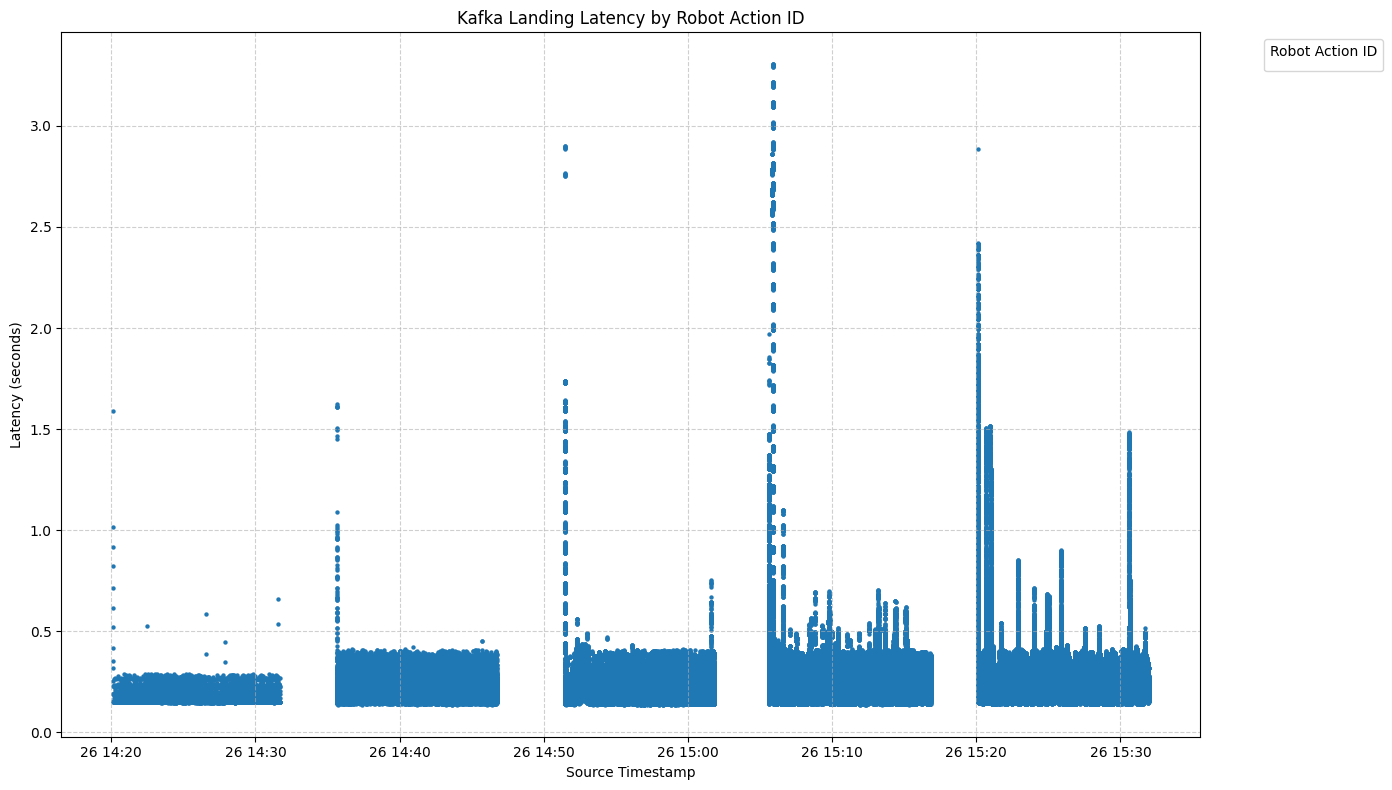

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

p99_threshold = df_cloud_filtered['ack_latency'].quantile(1)
p01_threshold = df_cloud_filtered['ack_latency'].quantile(0)
data_subset = df_cloud_filtered[(df_cloud_filtered['ack_latency'] <= p99_threshold) & (df_cloud_filtered['ack_latency'] > p01_threshold)].copy()

# data_subset = data_subset[
#     (data_subset["source_timestamp"] >= "2025-12-26 14:35:00+00:00") &
#     (data_subset["source_timestamp"] <= "2025-12-26 14:45:00+00:00")
# ]

plt.figure(figsize=(14, 8))
sns.scatterplot(
    data=data_subset,
    x="source_timestamp", 
    y="ack_latency", 
    palette="tab10",        # Choose a distinct color palette
    s=10,                   # Marker size
    marker='o',
    linewidth=0
)

plt.title("Kafka Landing Latency by Robot Action ID")
plt.xlabel("Source Timestamp")
plt.ylabel("Latency (seconds)")
plt.legend(title="Robot Action ID", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

/tmp/ipykernel_19140/3227445921.py:14: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(
/tmp/ipykernel_19140/3227445921.py:27: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title="Robot Action ID", bbox_to_anchor=(1.05, 1), loc='upper left')


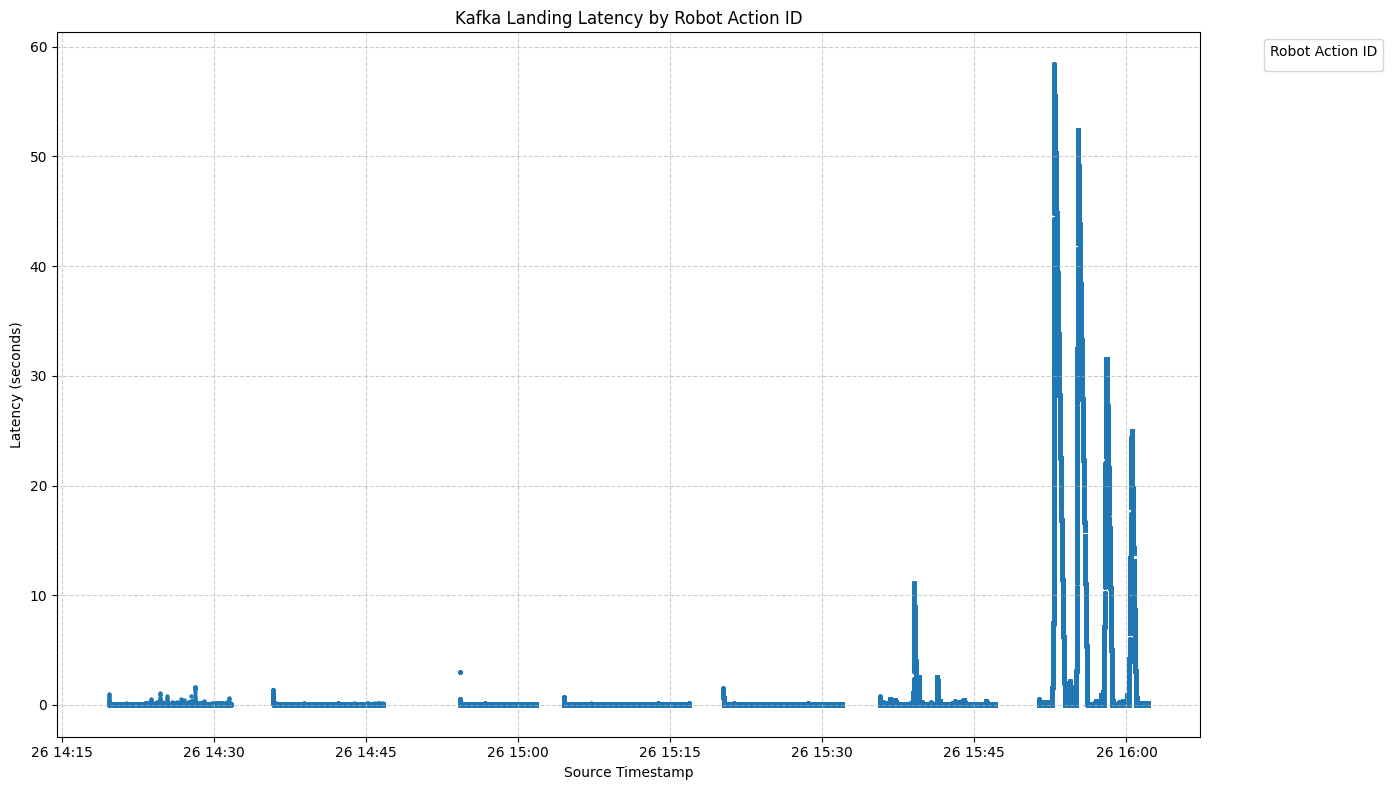

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

p99_threshold = df_edge_filtered['ack_latency'].quantile(1)
p01_threshold = df_edge_filtered['ack_latency'].quantile(0)
data_subset = df_edge_filtered[(df_edge_filtered['ack_latency'] <= p99_threshold) & (df_edge_filtered['ack_latency'] > p01_threshold)].copy()

# data_subset = data_subset[
#     (data_subset["source_timestamp"] >= "2025-12-26 14:35:00+00:00") &
#     (data_subset["source_timestamp"] <= "2025-12-26 14:45:00+00:00")
# ]

plt.figure(figsize=(14, 8))
sns.scatterplot(
    data=data_subset,
    x="source_timestamp", 
    y="ack_latency", 
    palette="tab10",        # Choose a distinct color palette
    s=10,                   # Marker size
    marker='o',
    linewidth=0
)

plt.title("Kafka Landing Latency by Robot Action ID")
plt.xlabel("Source Timestamp")
plt.ylabel("Latency (seconds)")
plt.legend(title="Robot Action ID", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()